In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from aging.plotting import format_plots, PlotConfig, save_factory, figure
from aging.behavior.pseudotime import compute_pseudotime, pseudotime_springplot

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.dana_save_path / "pseudotime", tight_layout=False)
c.save_path

PosixPath('/n/groups/datta/win/figures/ontogeny')

In [3]:
version = 7  # arhmm version
df = pd.read_parquet(f'/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/ontogeny_males_clean_v2.parquet')
# df = pd.read_parquet(f'/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/ontogeny_males_clean_20mins_v1.parquet')

In [4]:
def remove_crl(df):
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [5]:
df.columns

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76],
      dtype='object', name='relabeled_syllables')

In [6]:
def zscore(df):
    return (df - df.mean()) / df.std()

In [7]:
sample = []
for a, _df in df.groupby('age'):
    try:
        sample.append(_df.sample(n=16, random_state=1))
    except ValueError:
        sample.append(_df.sample(n=15, random_state=1))
sample = pd.concat(sample)
pseudo_df = compute_pseudotime(
    sample, remove_crl, k_neigh=6
)
pseudo_df.reset_index().loc[:, ["pseudotime_rank", "age"]].corr(method="spearman")

  0%|          | 0/5000 [00:00<?, ?it/s]

,pseudotime_rank,age
pseudotime_rank,1.000000,0.870003
age,0.870003,1.000000


In [8]:
colors = ['#DADAEB','#6A51A3']
sns.blend_palette(colors, 12)

[(0.8549019607843137, 0.8549019607843137, 0.9215686274509803),
 (0.8152864282968089, 0.8064436755094194, 0.8961014994232986),
 (0.775670895809304, 0.7579853902345252, 0.8706343713956171),
 (0.7360553633217993, 0.7095271049596309, 0.8451672433679354),
 (0.6947174163783161, 0.658961937716263, 0.8185928489042675),
 (0.6551018838908113, 0.6105036524413687, 0.7931257208765858),
 (0.6154863514033064, 0.5620453671664745, 0.7676585928489043),
 (0.5758708189158016, 0.5135870818915802, 0.7421914648212226),
 (0.5345328719723184, 0.46302191464821224, 0.7156170703575547),
 (0.49491733948481353, 0.4145636293733179, 0.6901499423298731),
 (0.45530180699730877, 0.36610534409842366, 0.6646828143021914),
 (0.41568627450980394, 0.3176470588235294, 0.6392156862745098)]

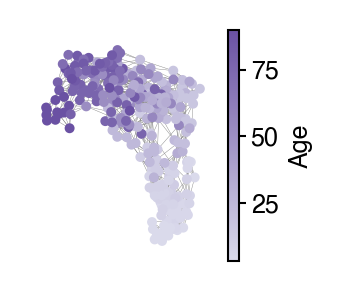

In [9]:
graph, pos, c, fig = pseudotime_springplot(
    sample,
    remove_crl,
    # xform_fun=zscore,
    k_neigh=6,
    seed=2,
    node_size=2.5,
    cmap=sns.blend_palette(colors, as_cmap=True),
)
# saver(fig, "pseudotime-ontogeny-spring-20mins");
saver(fig, "pseudotime-ontogeny-spring");

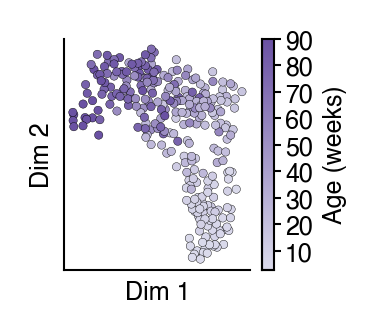

In [10]:
scatter_pos = np.array(list(pos.values()))

fig = figure(1, 1)
ax = fig.gca()
im = ax.scatter(
    *scatter_pos.T,
    c=c,
    cmap=sns.blend_palette(colors, as_cmap=True),
    s=4,
    lw=0.1,
    ec='k',
    # rasterized=True,
    # norm='log'
)
ax.set(xticks=[], yticks=[], xlabel="Dim 1", ylabel="Dim 2")
cb = fig.colorbar(im, ax=ax, label="Age (weeks)")
cb.set_ticks(np.arange(10, 100, 10, dtype='int'))
cb.set_ticks([], minor=True)
sns.despine()
saver(fig, "pseudotime-ontogeny");

In [11]:
merged_df = sample.join(pseudo_df)

In [12]:
merged_df.to_parquet(f'/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/ontogeny_males_clean_pseudotime_v02.parquet')
#merged_df.to_parquet(f'/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/ontogeny_males_clean_pseudotime_resampled_v02.parquet')
# merged_df.to_parquet(f'/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/ontogeny_males_clean_pseudotime_20mins_v02.parquet')

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/pandas/io/parquet.py:159: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


In [13]:
from sklearn.cross_decomposition import PLSRegression

In [14]:
mdl = PLSRegression(n_components=5)
x = remove_crl(merged_df)
y = x['pseudotime_rank']
x = x.filter(regex=r'\d')
mdl.fit(x, y)
mdl.score(x, y)

0.9575962206604264

In [15]:
mdl = PLSRegression(n_components=5)
x = remove_crl(merged_df)
y = x.index.get_level_values('age')
x = x.filter(regex=r'\d')
mdl.fit(x, y)
mdl.score(x, y)

0.8728871903913349